Linear Fit: y = 0.650x + -0.032, R² = 0.8112


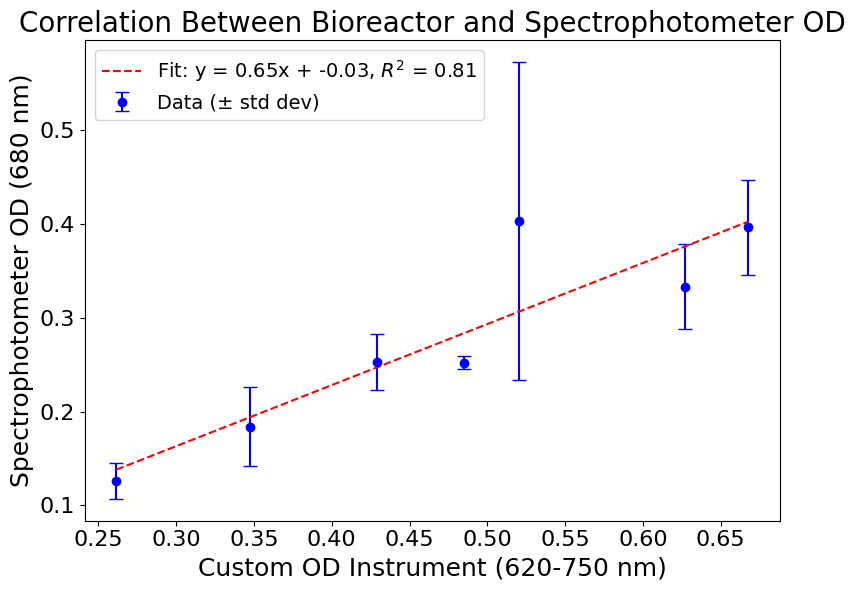

             datetime            bioreactor_time  OD_spec   OD_calc
0 2025-07-11 11:16:00 2025-07-11 11:32:30.103220    0.126  0.261519
1 2025-07-12 09:30:00 2025-07-12 09:37:16.517800    0.184  0.347330
2 2025-07-13 09:30:00 2025-07-13 09:42:28.939504    0.253  0.429351
3 2025-07-14 11:30:00 2025-07-14 11:48:07.440779    0.252  0.484848
4 2025-07-15 10:00:00 2025-07-15 09:52:53.772051    0.403  0.520533
5 2025-07-16 10:00:00 2025-07-16 09:58:06.161999    0.333  0.626807
6 2025-07-17 10:40:00 2025-07-17 11:03:31.543340    0.396  0.667839


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Step 1: Hardcoded spectrophotometer readings (date, time, OD mean, std dev)
spec_data = [
    {'datetime': '2025-07-11 11:16', 'OD_spec': 0.126, 'std': 0.019},
    {'datetime': '2025-07-12 09:30', 'OD_spec': 0.184, 'std': 0.042},
    {'datetime': '2025-07-13 09:30', 'OD_spec': 0.253, 'std': 0.030},
    {'datetime': '2025-07-14 11:30', 'OD_spec': 0.252, 'std': 0.007},
    {'datetime': '2025-07-15 10:00', 'OD_spec': 0.403, 'std': 0.169},
    {'datetime': '2025-07-16 10:00', 'OD_spec': 0.333, 'std': 0.045},
    {'datetime': '2025-07-17 10:40', 'OD_spec': 0.396, 'std': 0.051},
]
spec_df = pd.DataFrame(spec_data)
spec_df['datetime'] = pd.to_datetime(spec_df['datetime'])

# Step 2: Load bioreactor Red intensity data
file_path = 'color_log_2025-07-11_10-32-01.txt'
data = pd.read_csv(file_path, header=None, names=['Datetime', 'Red', 'Green', 'Blue', 'Clear'])
data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce')
data.dropna(subset=['Datetime'], inplace=True)

# Step 3: Calculate OD from Red intensity
I_o = 41850
data['OD_calc'] = np.log10(I_o / data['Red'])

# Step 4: For each spectrophotometer time, find closest bioreactor time
closest_matches = []
for _, row in spec_df.iterrows():
    target_time = row['datetime']
    closest_idx = (data['Datetime'] - target_time).abs().idxmin()
    match = data.loc[closest_idx]
    closest_matches.append({
        'datetime': target_time,
        'OD_spec': row['OD_spec'],
        'std': row['std'],
        'OD_calc': match['OD_calc'],
        'bioreactor_time': match['Datetime']
    })

match_df = pd.DataFrame(closest_matches)

# Step 5: Linear fit and R² calculation
x = match_df['OD_calc'].values
y = match_df['OD_spec'].values
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b
r2 = r2_score(y, y_pred)
print(f'Linear Fit: y = {m:.3f}x + {b:.3f}, R² = {r2:.4f}')

# Step 6: Plot
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=match_df['std'], fmt='o', capsize=5, label='Data (± std dev)', color='blue')
plt.plot(x, y_pred, color='red', linestyle='--', label=f'Fit: y = {m:.2f}x + {b:.2f}, $R^2$ = {r2:.2f}')

plt.xlabel('Custom OD Instrument (620-750 nm)', fontsize=18)
plt.ylabel('Spectrophotometer OD (680 nm)', fontsize=18)
plt.title('Correlation Between Bioreactor and Spectrophotometer OD', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Optional: print matched times for reference
print(match_df[['datetime', 'bioreactor_time', 'OD_spec', 'OD_calc']])
